In [14]:
cluster_seed=999
test_split_seed=7

# Load data

In [15]:
# Paths
wlw_data_path="../data/wlw_hildesheim.csv"
mastr_data_path="../data/niedersachsen_stromerzeuger_mastr_to_wlw_style.csv"
solar_data_path="../data/solar_data_wlw_hildesheim_search_05.csv"

In [16]:
import pandas as pd

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

from pv_rec.ml_lib import WlwProductEncoder
from pv_rec import data_factory
from pv_rec.ml_lib import ProductShelf
from pv_rec.recommender import Recommender

In [17]:
data_master=data_factory.DataMaster(mastr_filepath=mastr_data_path,
                                    wlw_filepath=wlw_data_path,
                                    solar_filepath=solar_data_path
                                    )

data is stored in attributes of data_master
``` python
data_master.mastr_data
data_master.wlw_data
```

Test dataset can also be seperated from the mastr data with the 
`data_master` object.

In [18]:
data_master.extract_test_data(data_master.mastr_data,
                              sample_size=100,
                              random_state=test_split_seed
                              )

There is no need to drop the test data from the mastr data or to assign the 
test data into a new variable, since the `data_master` object has a 
`data_mastr.test_data` attribute and the extraction is inplace, hence the 
data will automatically be dropped from the `data_master.mastr_data` attribute.

# Embedding Products
Next we need to embedd the products.
But before doing that, we chunk the data, since embedding large datasets can be
time consuming.

In [19]:
all_products=pd.concat(
    [
        data_master.mastr_data.product_categories,
        data_master.wlw_data.product_categories,
        ]
    )

## local run

In [20]:
model_name="Snowflake/snowflake-arctic-embed-l-v2.0"
encoder=WlwProductEncoder(products=all_products,
                          model_name=model_name
                          )

In [21]:
embeddings=encoder.embedd_it_local(encoder.products)

embedding texts


Batches:   0%|          | 0/122 [00:00<?, ?it/s]

# Cluster Embeddings

In [22]:
embeddings=embeddings.sort_index()

In [23]:
shelf=ProductShelf(clustering=KMeans(n_clusters=6,
                                     random_state=cluster_seed
                                     ),
                   scaler=StandardScaler()
                   )
shelf.fit(embeddings)
# response = shelf.cluster_products(embeddings)

## Assign Clusters to DataFrames

In [24]:
wlw_data=shelf.append_to_df(data_master.wlw_data, embeddings)
mastr_data=shelf.append_to_df(data_master.mastr_data, embeddings)

In [25]:
wlw_data

,distribution_area,employee_count,founding_year,installed_power,is_producer,is_sales,is_serviceprovider,is_wholesales,num_modules,product_categories,product_label_0,product_label_5,product_label_4,product_label_3,product_label_2,product_label_1
1. GTA GmbH,National,10-19,1986,49.000000,True,True,True,True,260,"{CNC-Frästeile aus Aluminium, Stanzteile aus M...",4.0,2.0,0.0,0.0,0.0,0.0
74dpi - internetlösungen,Lokal,1-4,2004,11.300000,False,False,True,False,58,"{Web-Design, Suchmaschinenmarketing (SEA/SEM),...",0.0,0.0,5.0,0.0,0.0,0.0
A P A R T A GmbH,National,1-4,0,13.800000,True,False,True,False,71,"{Schwerlastregale, Lagerregale, Industrieregal...",0.0,4.0,0.0,2.0,0.0,0.0
A. Wiethoff Zerspanungstechnik,Europa,10-19,0,0.000000,True,False,True,False,0,"{Formdrehteile, Verzahnung im Lohn, Drehteile ...",3.0,2.0,1.0,0.0,0.0,0.0
ACCURATA Informationssysteme GmbH,Weltweit,5-9,0,84.800000,True,False,True,False,437,"{Entwicklung von Software, Datenbank-Software,...",1.0,0.0,4.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
webfinisher,National,unknown,0,12.500000,False,False,False,False,65,{},NaN,NaN,NaN,NaN,NaN,NaN
wena³,National,1-4,0,0.000000,False,False,True,False,0,"{3-D Animation, 3-D Werbefilme, Architekturvis...",0.0,1.0,2.0,3.0,0.0,0.0
wheels4you GmbH,National,5-9,0,53.200001,False,True,True,False,273,"{Lkw-Reifen, Reifen für Motorräder, Reifen für...",2.0,4.0,0.0,0.0,0.0,0.0
Ölkers GmbH,National,5-9,2004,6.800000,False,False,True,False,35,"{CNC-Metallbearbeitung, CNC-Dreharbeiten im Lo...",4.0,0.0,0.0,0.0,0.0,0.0


# Hierarchical Clustering of Companies

In [26]:
recommender_obj=Recommender()

In [27]:
affinity_scores=recommender_obj.fit(wlw_data=wlw_data.copy(),
                                    mastr_data=mastr_data.copy(),
                                    method="ward",
                                    metric="euclidean",
                                    )

2025-10-14 16:58:26 [info     ] Preparing data                
2025-10-14 16:58:26 [info     ] Map categorical data          
2025-10-14 16:58:26 [info     ] handle NaNs                   
2025-10-14 16:58:26 [info     ] Scaling data                  
2025-10-14 16:58:26 [info     ] create linkage tree           
2025-10-14 16:58:28 [info     ] Get cluster labels            
2025-10-14 16:58:28 [info     ] Get number of Mastr companies in clusters
2025-10-14 16:58:28 [info     ] Get PV affinity scores        
2025-10-14 16:58:28 [info     ] Model fitted                   duration=1.9896209239959717
2025-10-14 16:58:28 [info     ] Store column schema           
2025-10-14 16:58:28 [info     ] get all feature averages for clusters


In [28]:
affinity_scores

,total_companies,mastr_data,percent
cluster_52,7.0,3.0,0.428571
cluster_23,55.0,29.0,0.527273
cluster_18,32.0,16.0,0.500000
cluster_3,6.0,6.0,1.000000
cluster_19,30.0,14.0,0.466667
cluster_5,39.0,7.0,0.179487
cluster_27,18.0,9.0,0.500000
cluster_21,28.0,14.0,0.500000
cluster_4,17.0,2.0,0.117647
cluster_24,23.0,23.0,1.000000


 # Show results

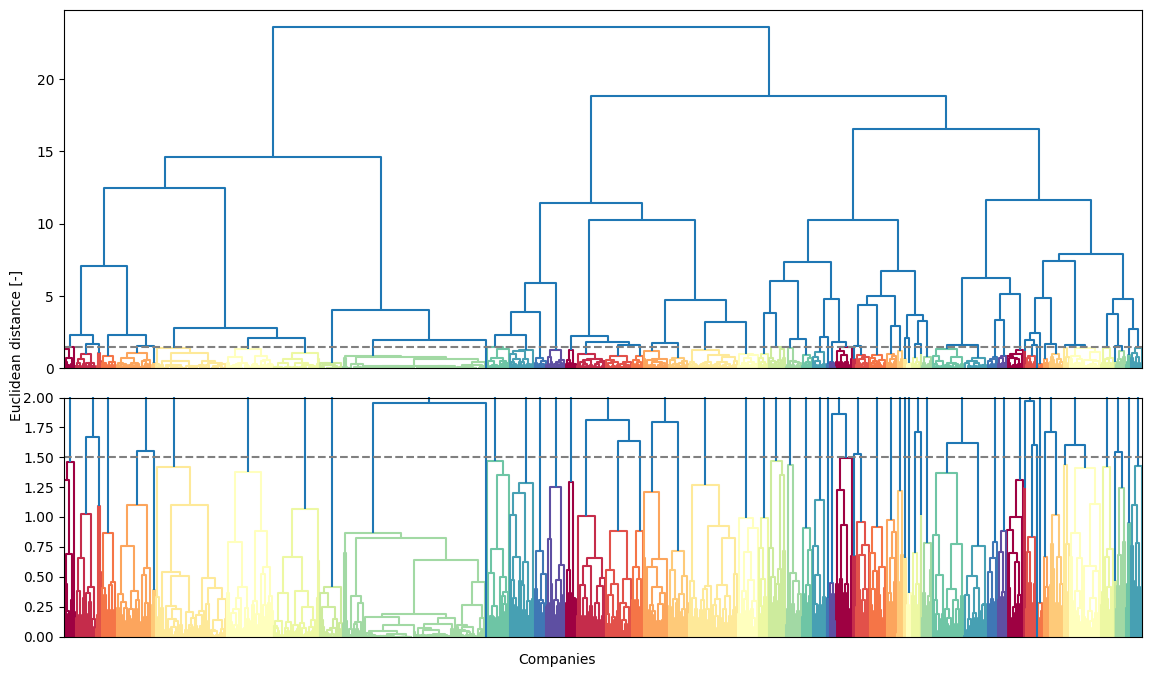

In [29]:
recommender_obj.plot()

 # Recommend to new companies

## Embedd Test Data products

In [30]:
# flatten products in test data
flat_test_products=sorted([
    item for sublist in data_master.test_data.product_categories
    for item in sublist
    ]
    )

In [31]:
encoder.products=flat_test_products

In [32]:
test_embeddings=encoder.embedd_it_local(
    encoder.products
    )

embedding texts


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

## Append embedding clusters to test data

In [33]:
test_data=shelf.append_to_df(data_master.test_data, test_embeddings)

## Assign affinity scores to test data

In [34]:
test_affinity_scores, company_results=recommender_obj.recommend(test_data)

2025-10-14 16:58:30 [info     ] map categorical data          
2025-10-14 16:58:30 [info     ] handle nans                   
2025-10-14 16:58:30 [info     ] set columns in correct order  
2025-10-14 16:58:30 [info     ] scale data                    
2025-10-14 16:58:30 [info     ] Get closest cluster to new data


# Calc recall value

In [35]:
recall_value=recommender_obj.recall(test_affinity_scores)

## Show recall histogram

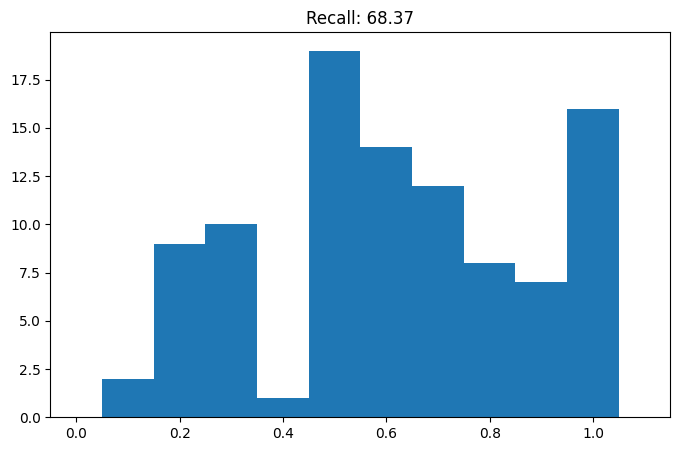

In [36]:
recommender_obj.plot_recall(pv_affinity=test_affinity_scores,
                            recall=recall_value,
                            ax=None
                            )